In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import (chi2, mutual_info_classif, f_classif)

from utils.constants import STAGE_DIR, ANALYSIS_DIR
from utils.dataload import load_data
from utils.display import cdisplay
from utils.plots import plot_features_scores
from utils.transformers import SelectKBestTransformer, ReliefFTransformer

In [87]:
RESAMPLED = True
PLOT_DIR = 'selection'

In [88]:
sufix = '_resampled' if RESAMPLED else ''

In [89]:
X_train = load_data(
    STAGE_DIR / 'preprocess' / f'X_train{sufix}.parquet',
    load_func=pd.read_parquet)
y = load_data(
    STAGE_DIR / 'preprocess' / f'y{sufix}.parquet',
    load_func=pd.read_parquet)

# Univariate feature selection

## Chi-squared $\chi^2$

In [90]:
univariate_selection_1 = SelectKBestTransformer(chi2, k=40)
univariate_selection_1 = univariate_selection_1.fit(X_train, y)
univariate_features_train_1 = univariate_selection_1.transform(X_train)

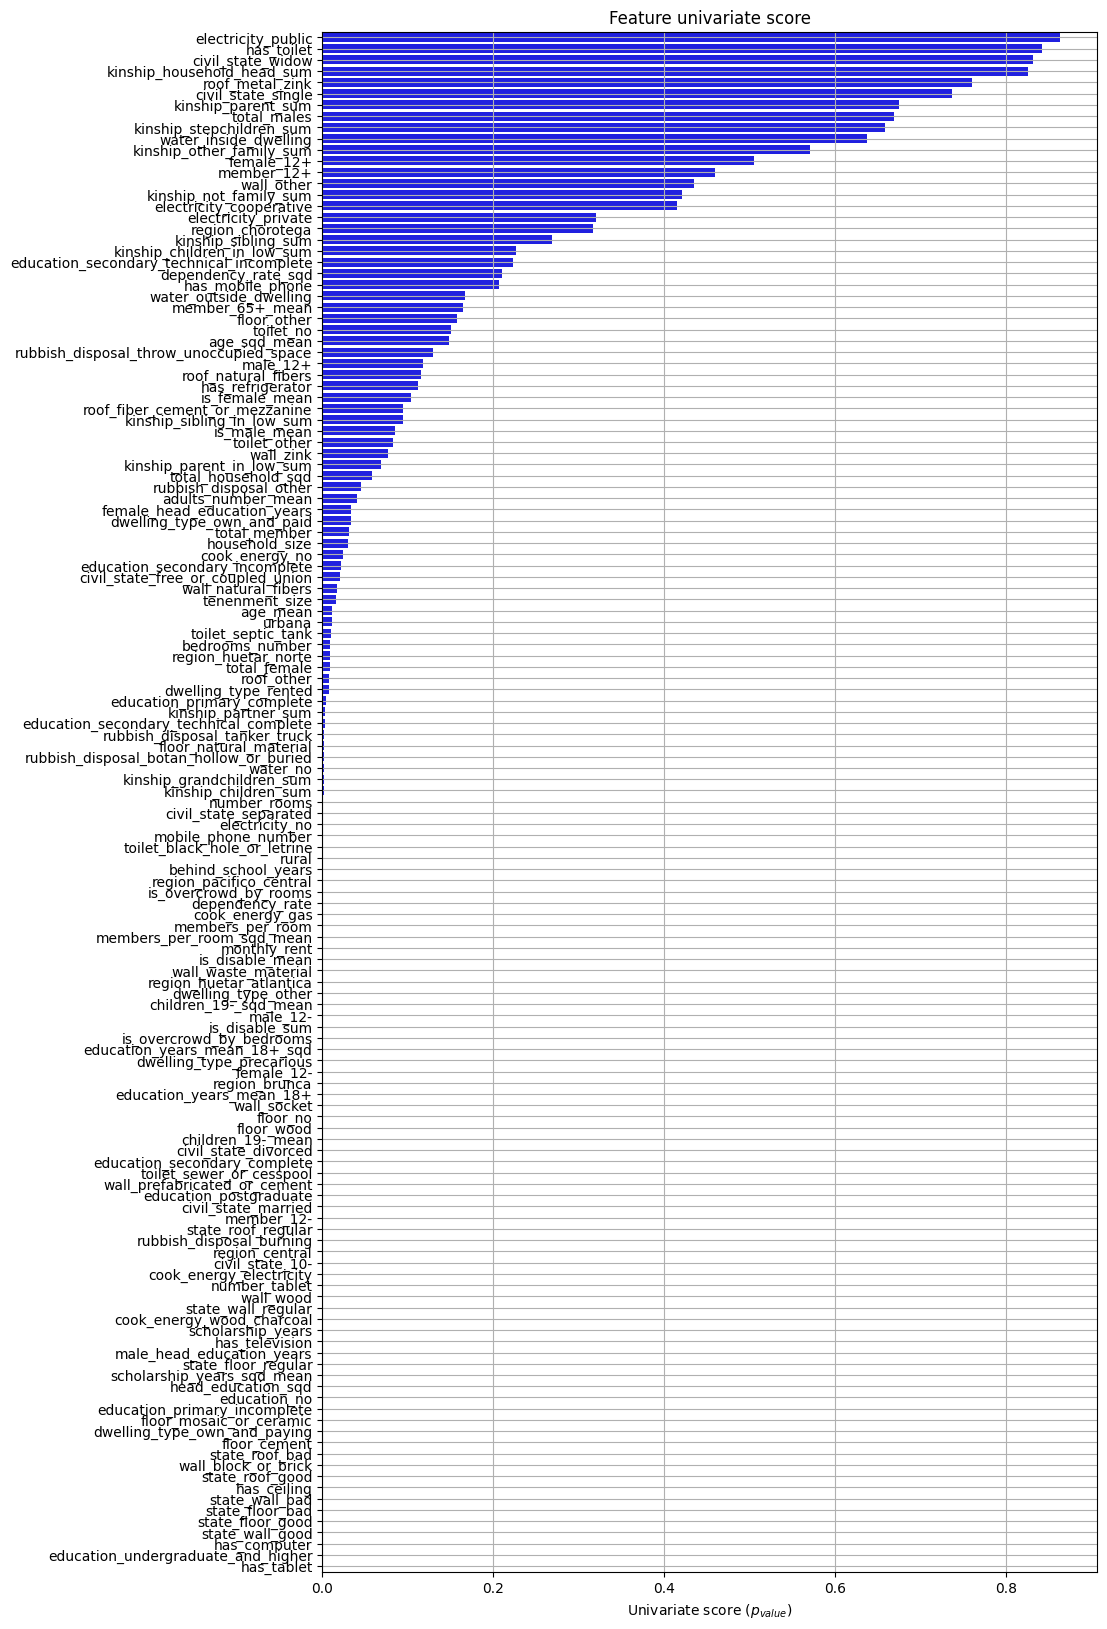

In [91]:
scores_1 = univariate_selection_1.pvalues_
plot_features_scores(X_train, scores_1, metric_label=r'$p_{value}$')
plt.savefig(
    ANALYSIS_DIR / 'images' / PLOT_DIR / f'fs_x2{sufix}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Mutual information

In [92]:
univariate_selection_2 = SelectKBestTransformer(mutual_info_classif, k=100)
univariate_selection_2 = univariate_selection_2.fit(X_train, y['y'])
univariate_features_train_2 = univariate_selection_2.transform(X_train)

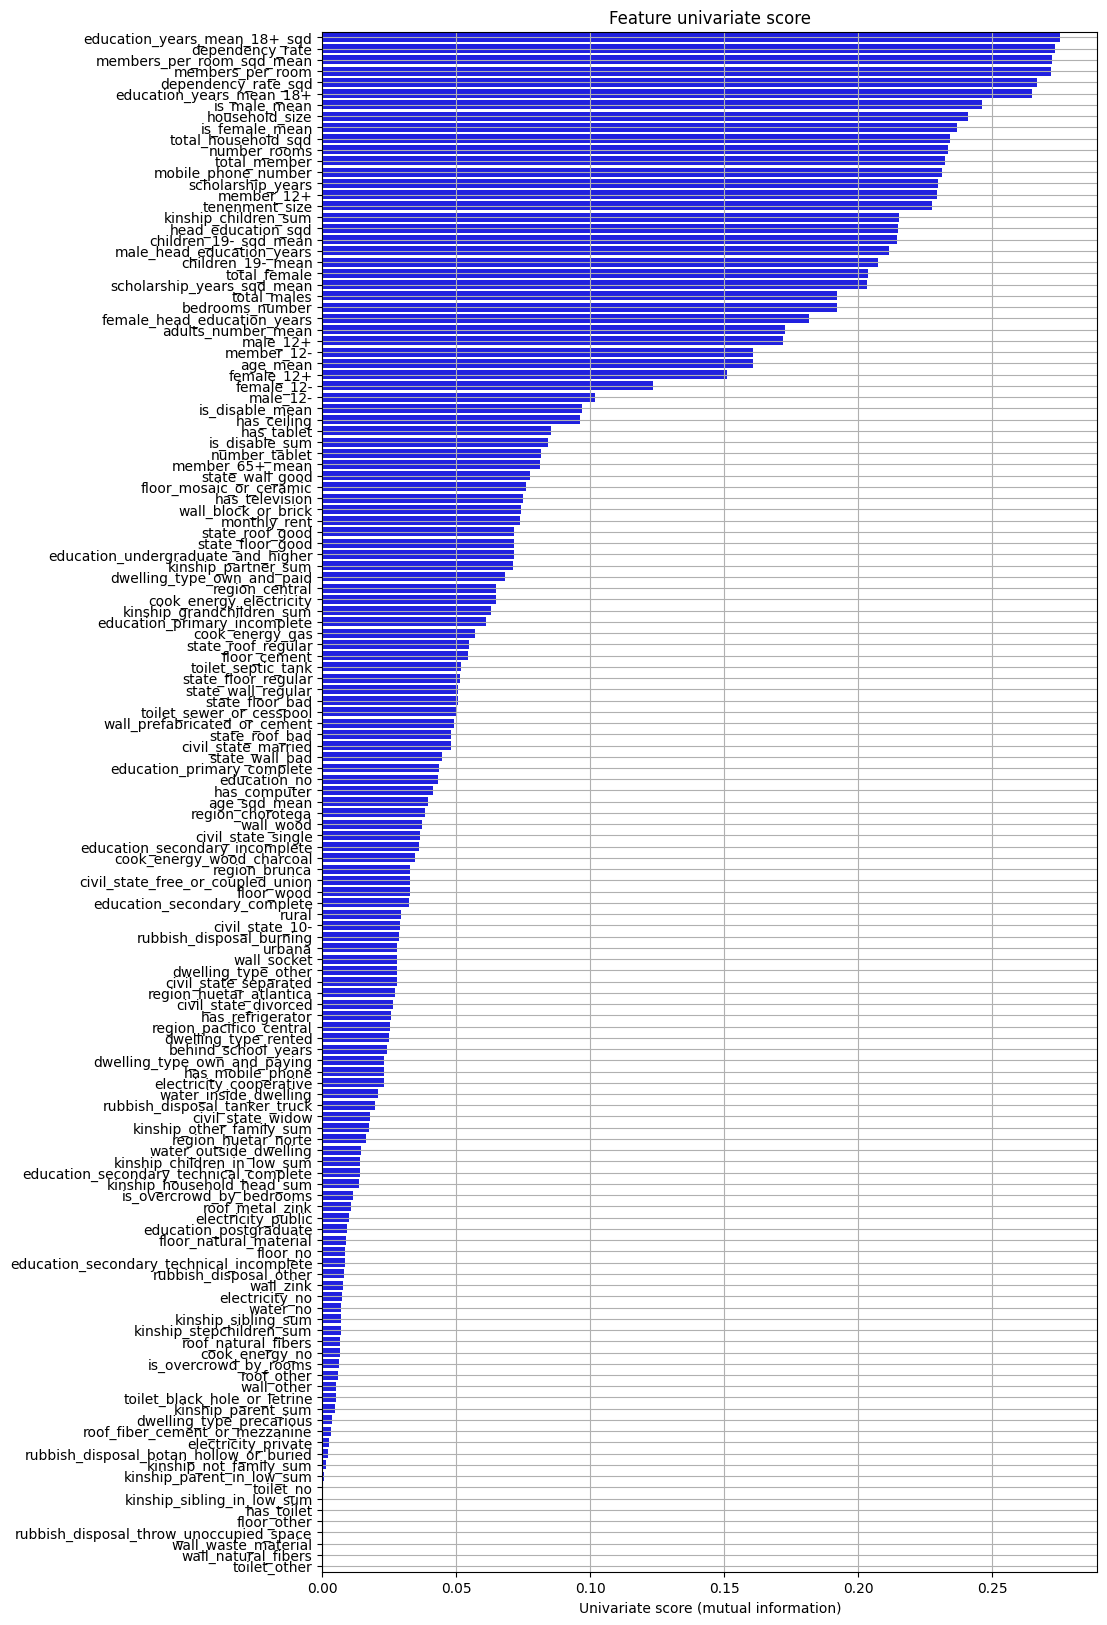

In [93]:
scores_2 = univariate_selection_2.scores_
plot_features_scores(X_train, scores_2, metric_label=r'mutual information')
plt.savefig(
    ANALYSIS_DIR / 'images' / PLOT_DIR / f'fs_mi{sufix}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## ANOVA selection

In [94]:
univariate_selection_3 = SelectKBestTransformer(f_classif, k=100)
univariate_selection_3 = univariate_selection_3.fit(X_train, y['y'])
univariate_features_train_3 = univariate_selection_3.transform(X_train)

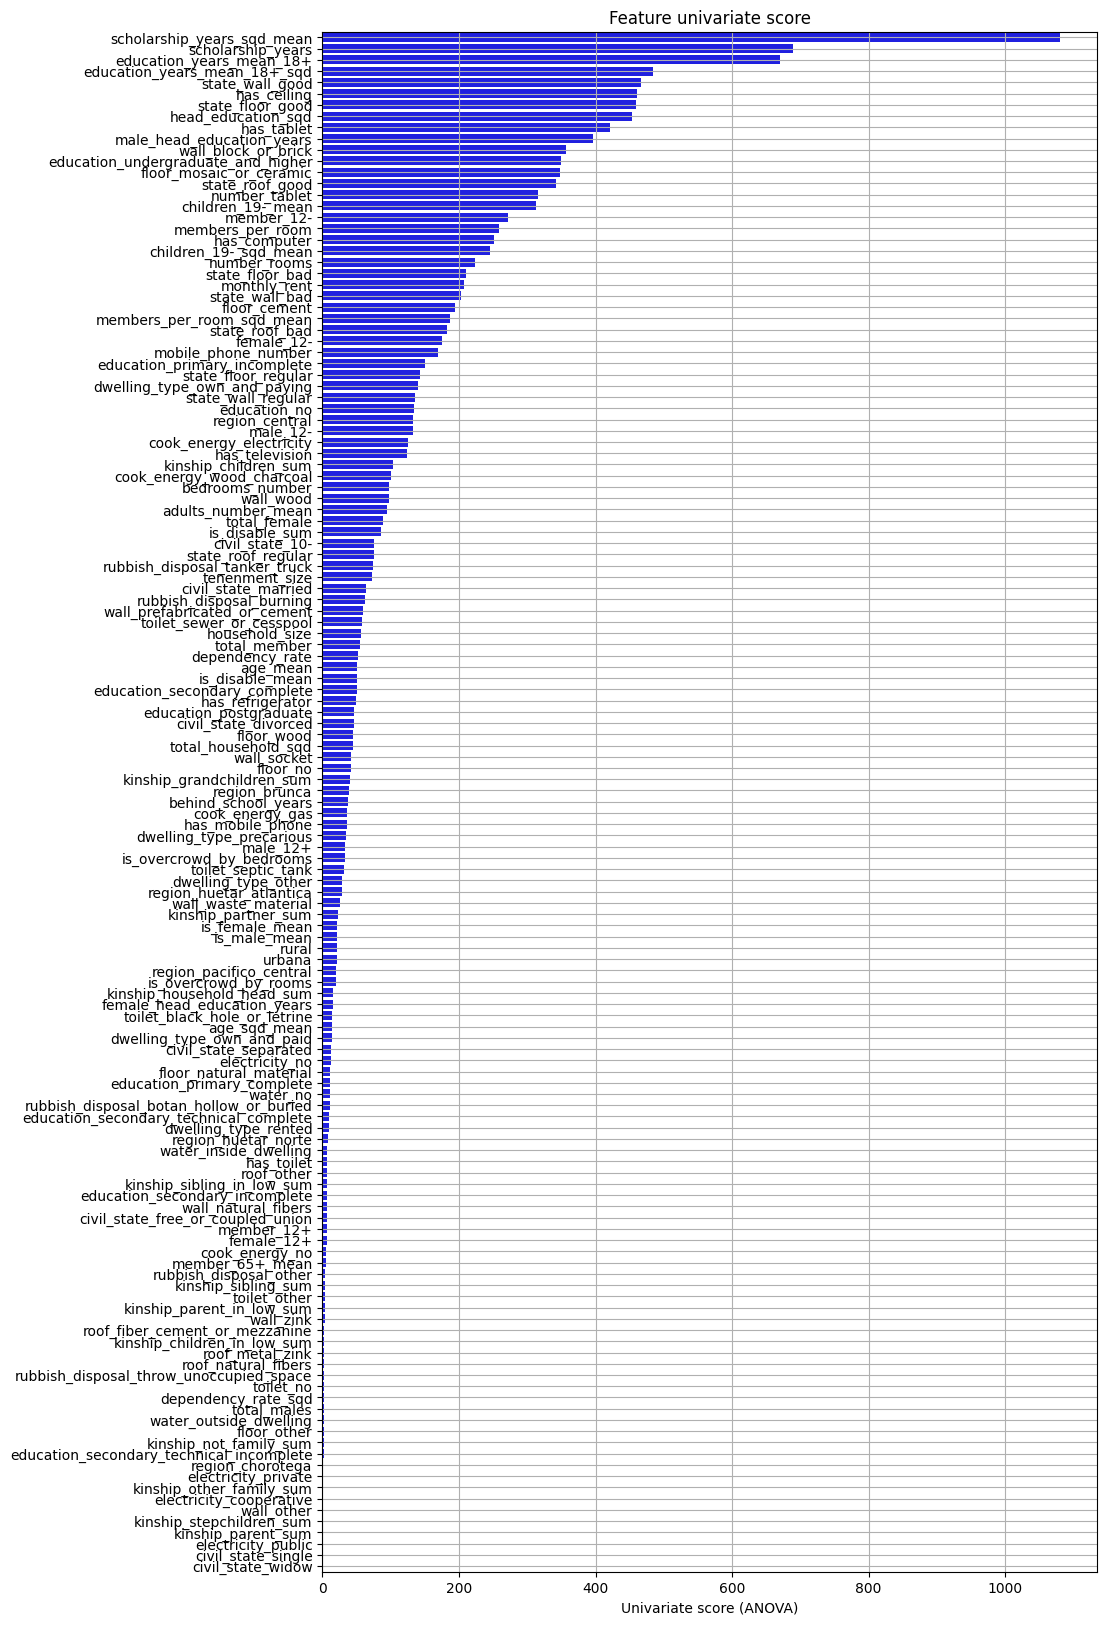

In [95]:
scores_3 = univariate_selection_3.scores_
plot_features_scores(X_train, scores_3, metric_label=r'ANOVA')
plt.savefig(
    ANALYSIS_DIR / 'images' / PLOT_DIR / f'fs_anova{sufix}.pdf',
    dpi=300,
    bbox_inches='tight'
)

## Summary

In [ ]:
from utils.transformers import MinMaxScalerTransformer

summary_scores = MinMaxScalerTransformer().fit_transform(pd.DataFrame({
    '$p_{value}$': scores_1,
    'Mutual Information': scores_2,
    'ANOVA': scores_3,
}, index=X_train.columns)).sort_values([
    '$p_{value}$',
    'Mutual Information',
    'ANOVA'
], ascending=False)

In [ ]:
ax = summary_scores.plot(
    kind='barh',
    stacked=True,
    grid=True,
    figsize=(10, 25),
    title='Feature Univariate Score'
)

ax.figure.savefig(
    ANALYSIS_DIR / 'images' / PLOT_DIR / f'fs_univariate{sufix}.pdf',
    dpi=300,
    bbox_inches='tight'
)

# Multivariate feature selection

In [ ]:
multivariate_selection = ReliefFTransformer(n_features_to_keep=100)
multivariate_selection.fit(X_train, y)
multivariate_features_train = multivariate_selection.transform(X_train)

In [ ]:
plot_features_scores(X_train, abs(multivariate_selection.feature_scores), method='multivariate', metric_label='Relief')
plt.savefig(
    ANALYSIS_DIR / 'images' / PLOT_DIR / f'fs_relief{sufix}.pdf',
    dpi=300,
    bbox_inches='tight'
)

# Save selected datasets

In [ ]:
univariate_features_train_1.to_parquet(STAGE_DIR / 'selection' / f'X_train_x2{sufix}.parquet')

In [ ]:
univariate_features_train_2.to_parquet(STAGE_DIR / 'selection' / f'X_train_mi{sufix}.parquet')

In [ ]:
univariate_features_train_3.to_parquet(STAGE_DIR / 'selection' / f'X_train_anova{sufix}.parquet')

In [ ]:
multivariate_features_train.to_parquet(STAGE_DIR / 'selection' / f'X_train_relief{sufix}.parquet')